# Assignment 2
## Kaggle Competition

# Santander Customer Transaction Prediction
At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.


# Dataset
Tha dataset is taken from https://www.kaggle.com/c/santander-customer-transaction-prediction/data

File descriptions

train.csv - the training set.

test.csv - the test set. 

The test set contains some rows which are not included in scoring.
sample_submission.csv - a sample submission file in the correct format.


# Abstract
At Santander our mission is to help people and help businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our method is firstly to analyze the distribution of the dataset, the condition of balance in the dataset, average number and standard deviation of both rows and columns.

Then we use the H2O AUTOML platform to generate the best models, and use the best model to predict the value in the test datset, and the rank is 1948 out of 3000 which was not a good score and then we started to train the model using LightGBM and predicted the target.
The final step is tunning the hyperparameters of the model by adding more number of leaves, maxbin,reducing the learning rate and adding more parameters.
We got even better outcome of 589 out of 3000 after tunning the hyperparameters and training the best model to predict the results.

# Impoting Libraries

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set_style('whitegrid')
import time
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("C:/Users/Dell/Desktop/Kaggle/santander/"))

import gc
import logging
import datetime
import warnings
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')


['.ipynb_checkpoints', 'catboost_info', 'GLM_H2O.ipynb', 'LeaderboardRank_589LGBM.png', 'sample_submission.csv', 'Santander_Customer_Transaction_Prediction.ipynb', 'STCP_lightgbm.ipynb', 'submission.csv', 'submission1.csv', 'submission2.csv', 'submission3.csv', 'submission4.csv', 'submission5.csv', 'test.csv', 'train.csv']


# Loading and Describing the dataset

In [2]:
train_df = pd.read_csv('C:/Users/Dell/Desktop/Kaggle/santander/train.csv')
print('Rows: ',train_df.shape[0],'Columns: ',train_df.shape[1])
train_df.info()

Rows:  200000 Columns:  202
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


### The Dataset containing 200 numeric feature variables from var_0 to var_199 and a target value

In [3]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [23]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [4]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

#### Training data contains:

ID_code (string);
target;
200 numerical variables, named from var_0 to var_199;
Test contains:

ID_code (string);
200 numerical variables, named from var_0 to var_199;

In [48]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [49]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


# Observations:

1) standard deviation is relatively large for both train and test variable data;

2) min, max, mean, sdt values for train and test data looks quite close;

3) mean values are distributed over a large range.


The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for few of the features.

# Data Visualization

### Plotting the Scatter Plot

In [24]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

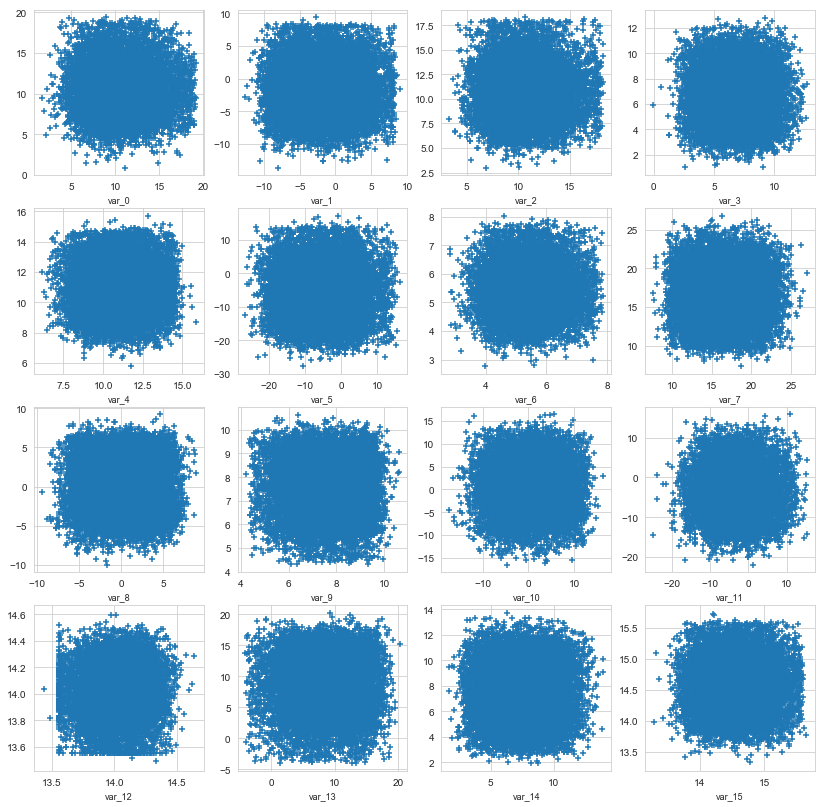

In [25]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

# Checking the distribution of target value in train dataset

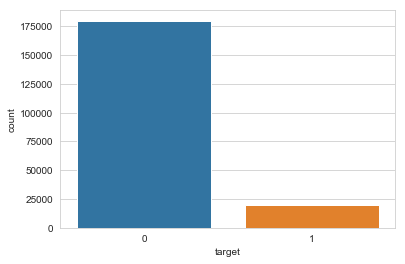

In [5]:
sns.countplot(train_df['target'])
sns.set_style('whitegrid')

### The data is unbalanced with respect with target value

# Density Plot of features

In [26]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

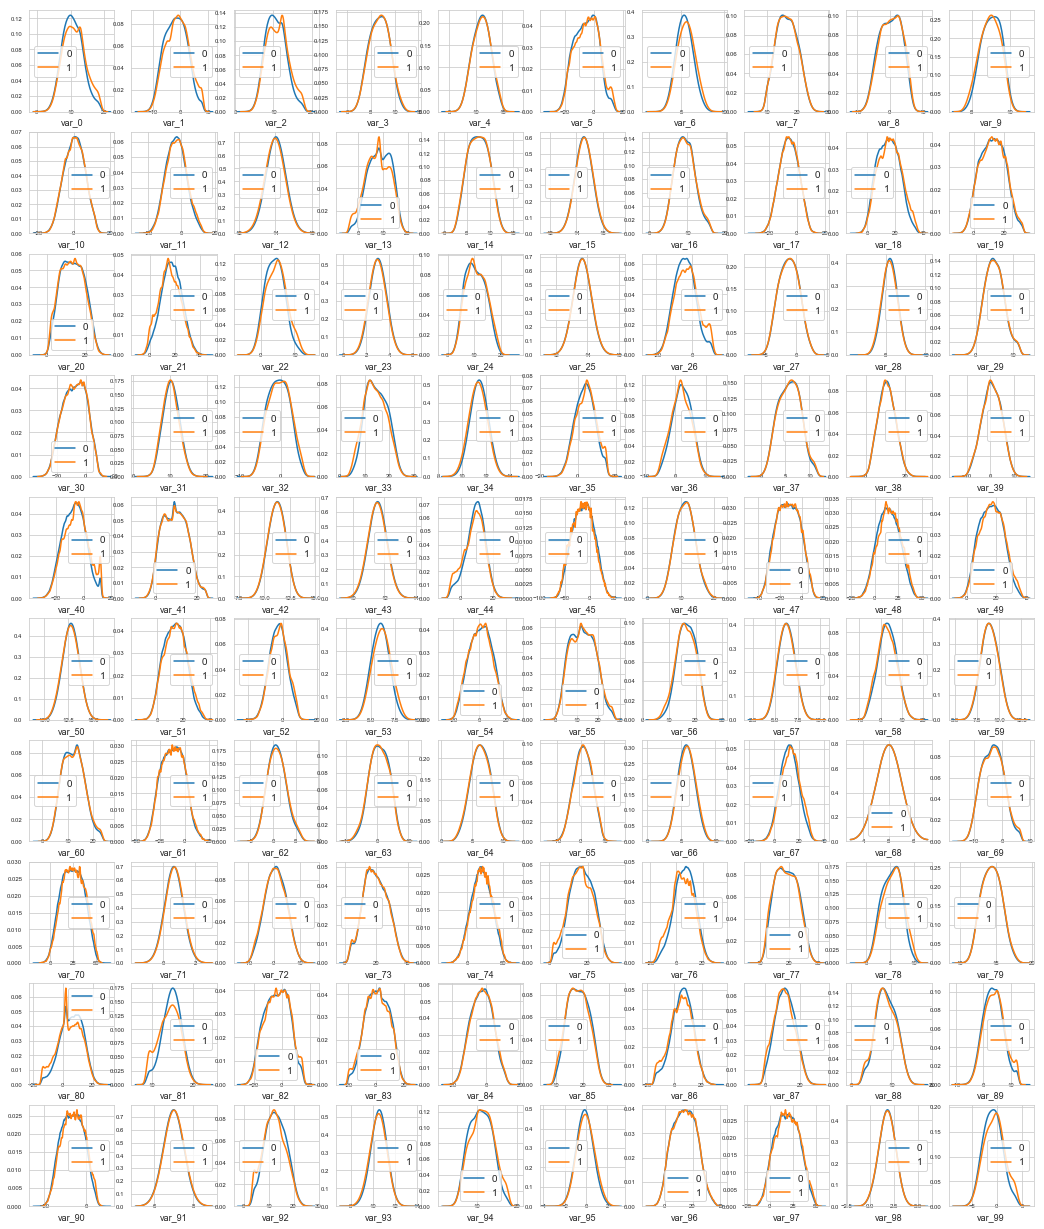

In [27]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

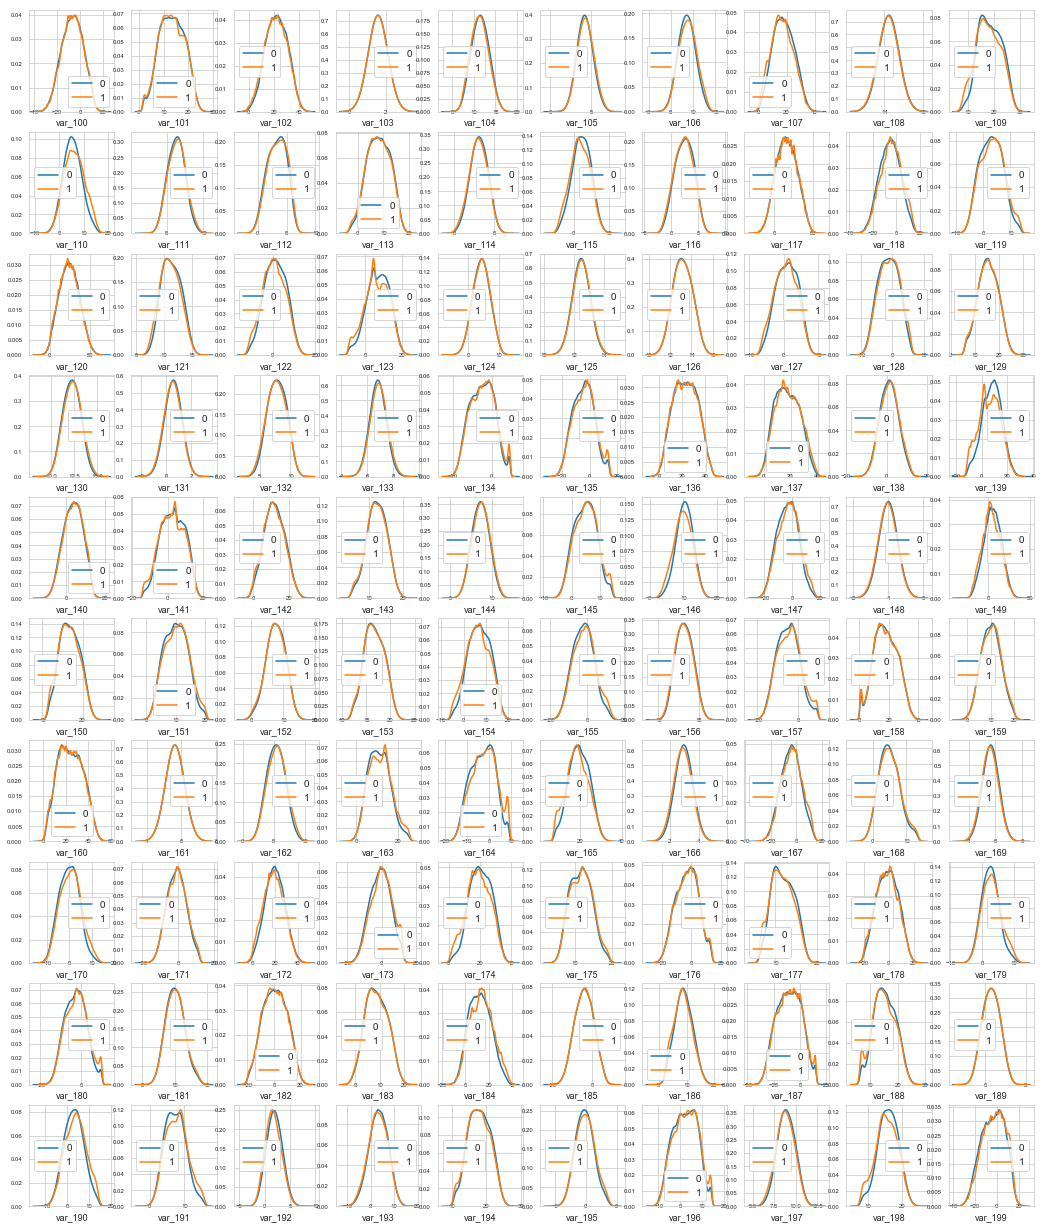

In [28]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We observe that there is a considerable number of features with significant different distribution for the two target values.
For example, var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_109, var_139 and many others.

Also some features, like var_2, var_13, var_26, var_55, var_175, var_184, var_196 shows a distribution that resambles to a bivariate distribution.

We will take this into consideration in the future for the selection of the features for our prediction model.

<Figure size 432x288 with 0 Axes>

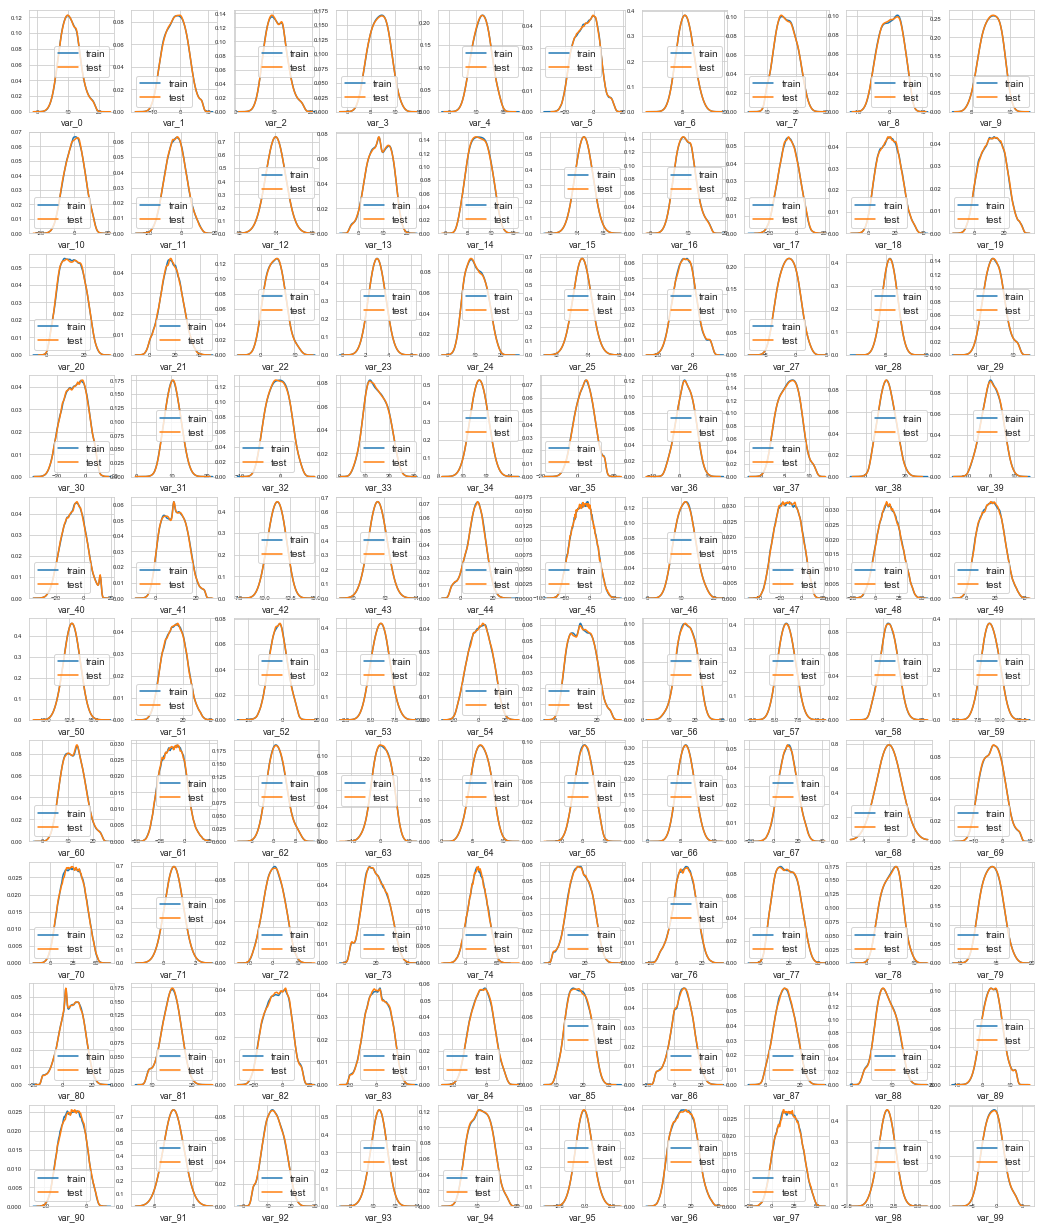

In [29]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

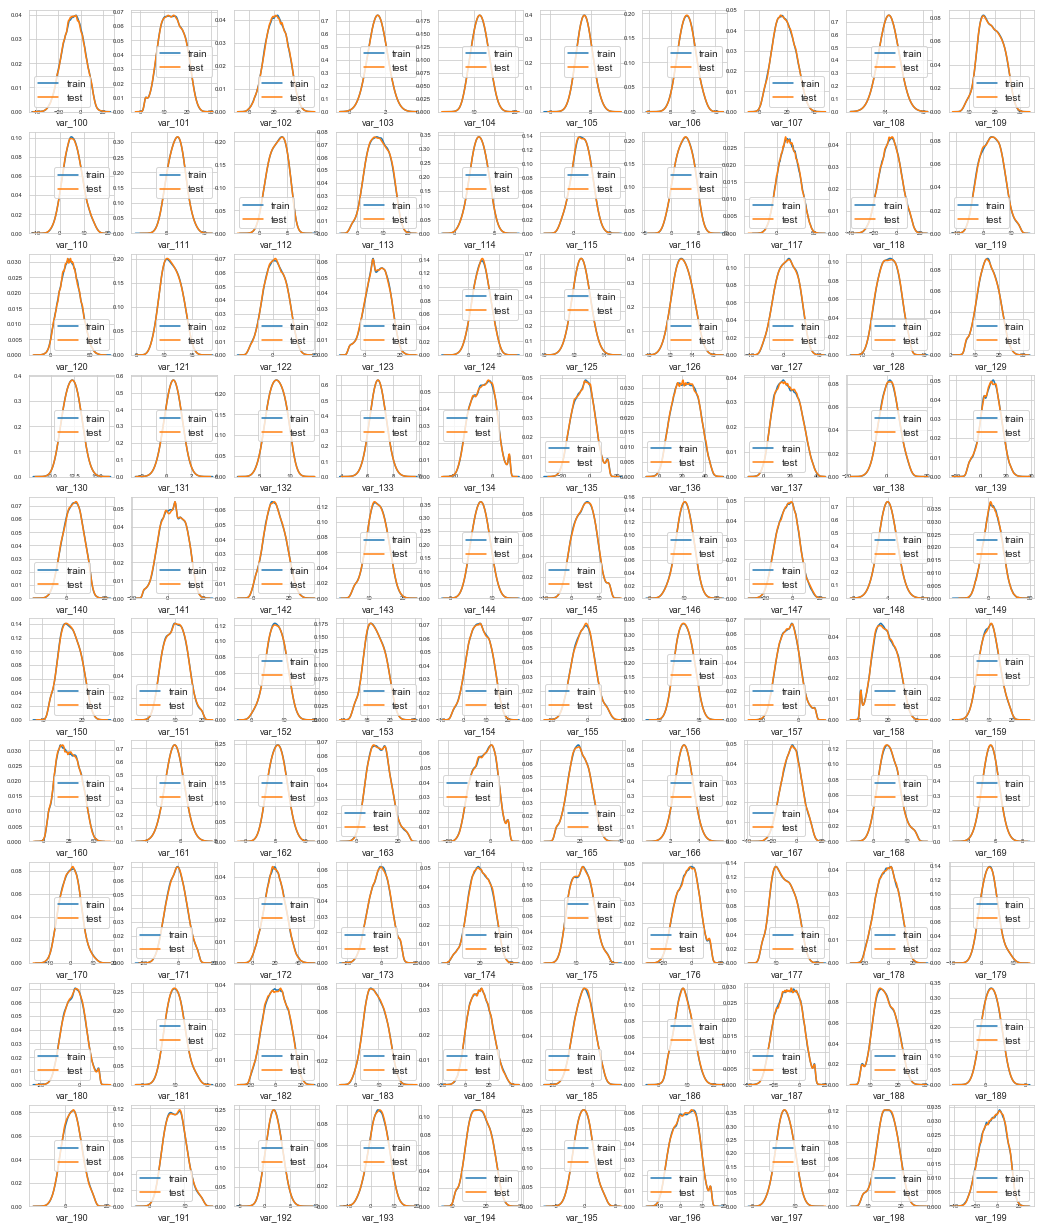

In [30]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

### The train and test seems to be well ballanced with respect with distribution of the numeric variables.

# Distribution of mean and standard deviation
Let's check the distribution of the mean values per row in the train and test set.

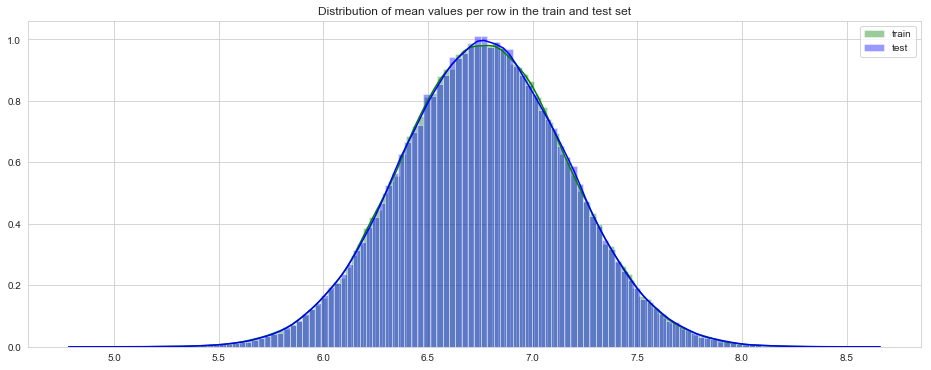

In [31]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## Checking the distribution of the mean values per columns in the train and test set

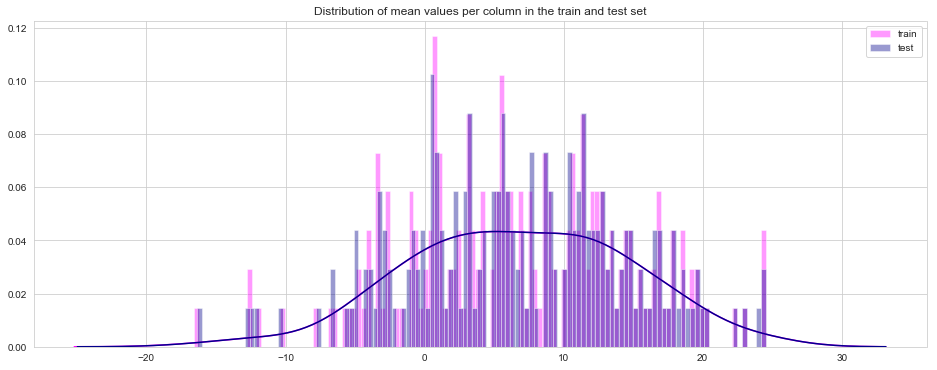

In [32]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## Let's show the distribution of standard deviation of values per row for train and test datasets

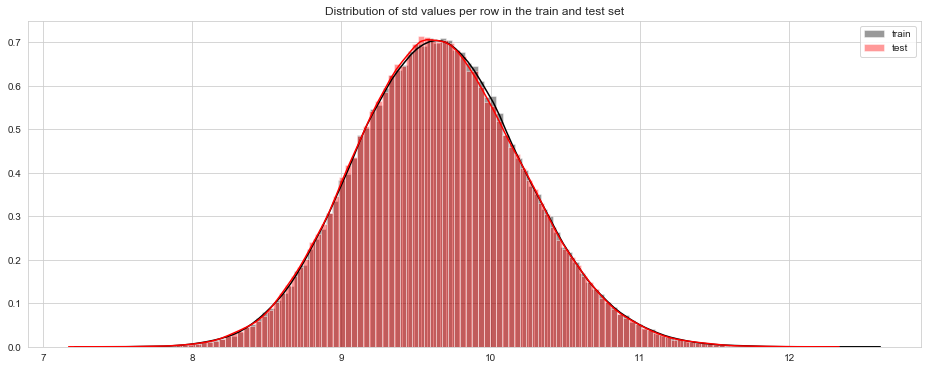

In [33]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

## Let's check the distribution of the standard deviation of values per columns in the train and test datasets

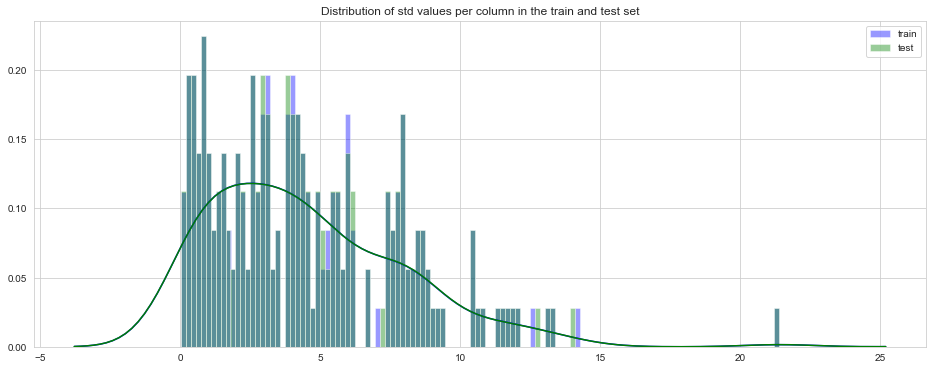

In [34]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

## Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target.

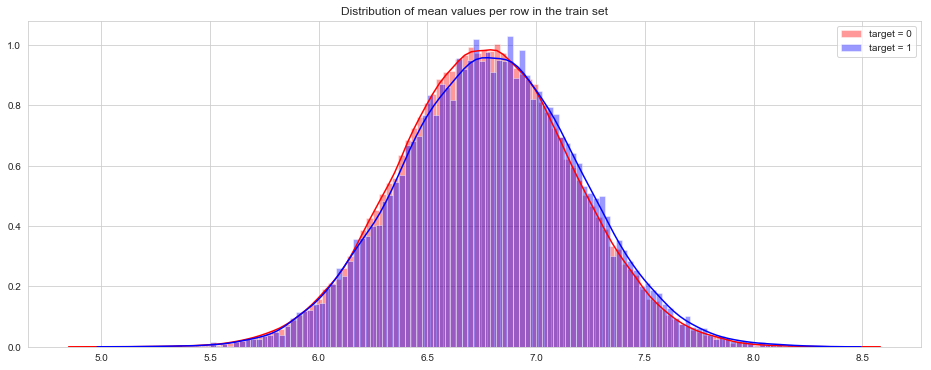

In [35]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target

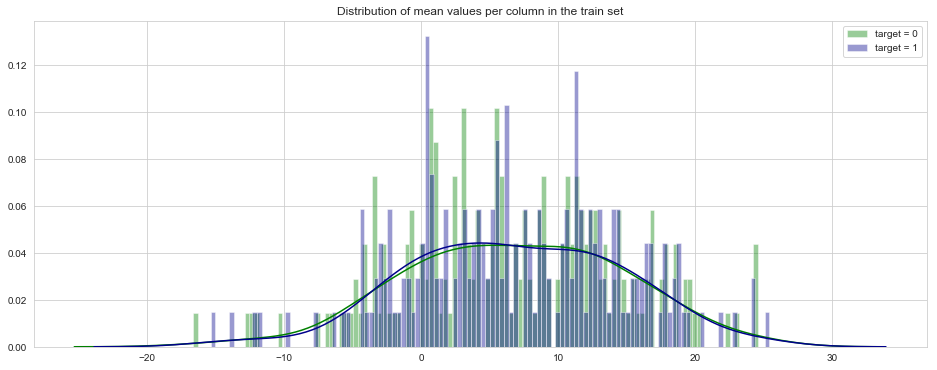

In [36]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Distribution of min and max

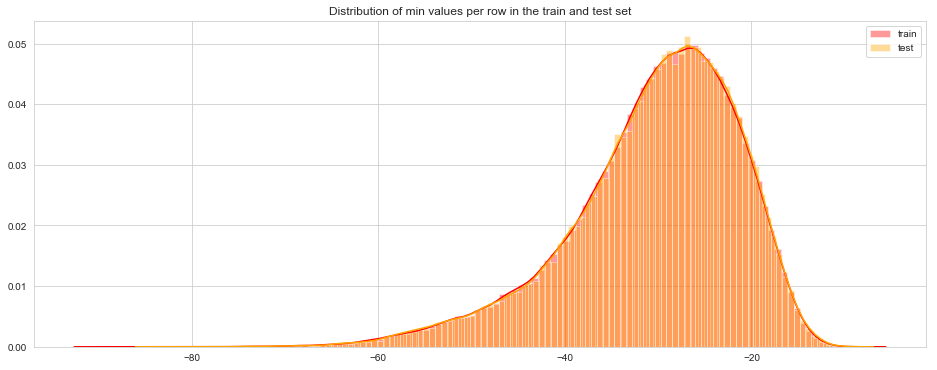

In [37]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### A long queue to the lower values for both, extended as long as to -80 for test set, is observed

 ## Let's now show the distribution of min per column in the train and test set

plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# Let's check now the distribution of max values per rows for train and test set

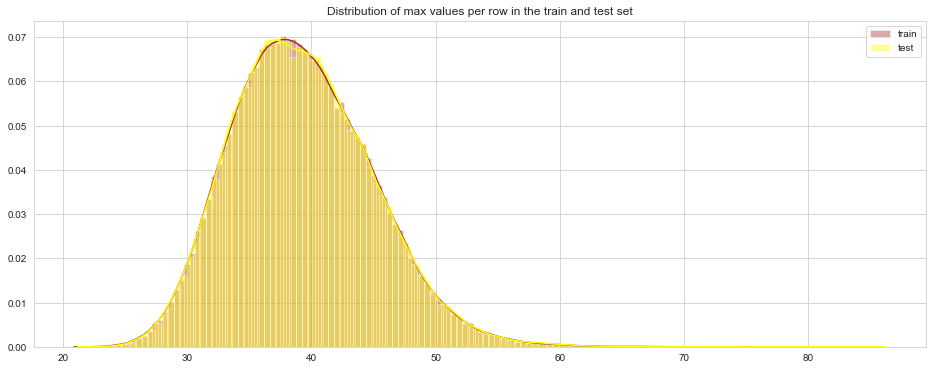

In [39]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## Let's show now the max distribution on columns for train and test set

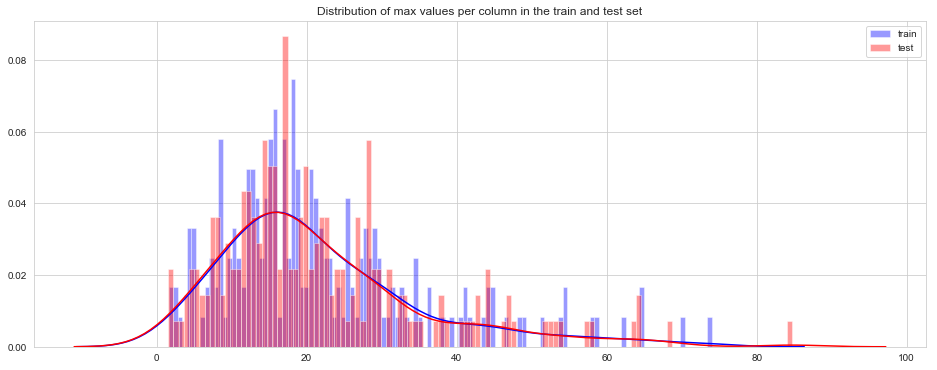

In [40]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()


## Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1)

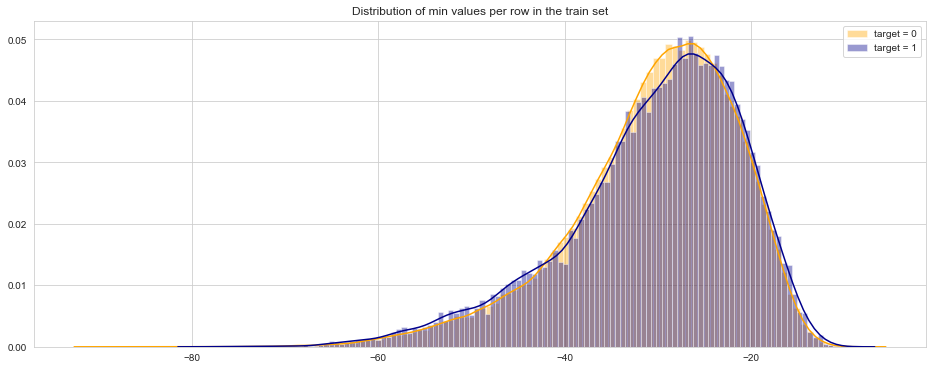

In [41]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### We show here the distribution of min values per columns in train set.

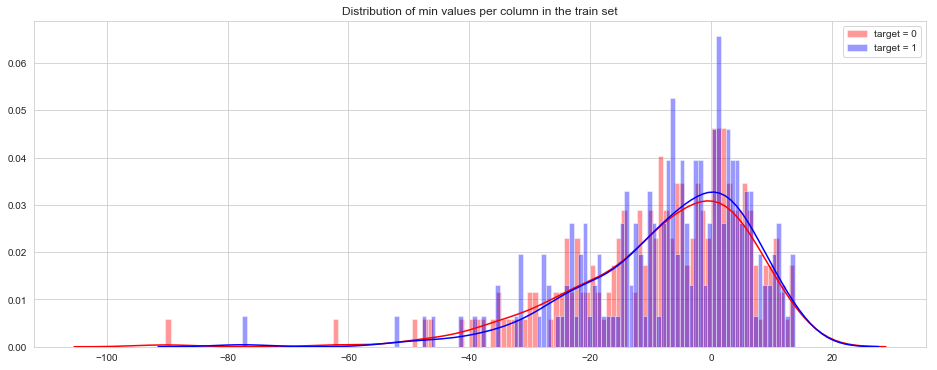

In [42]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Let's show now the distribution of max values per rown in the train set

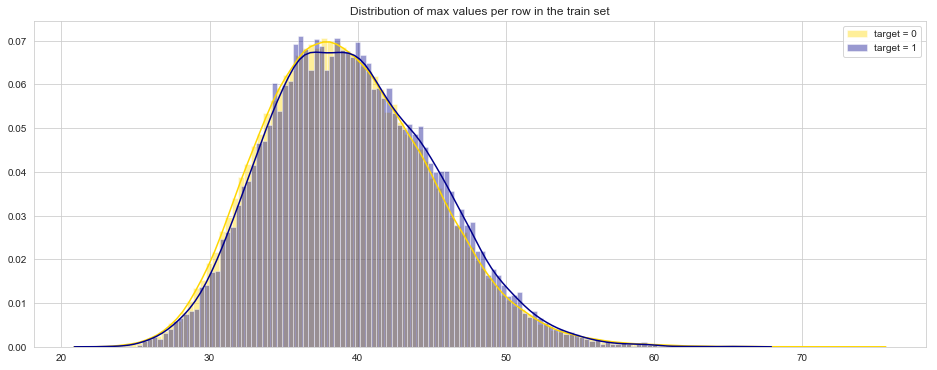

In [43]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

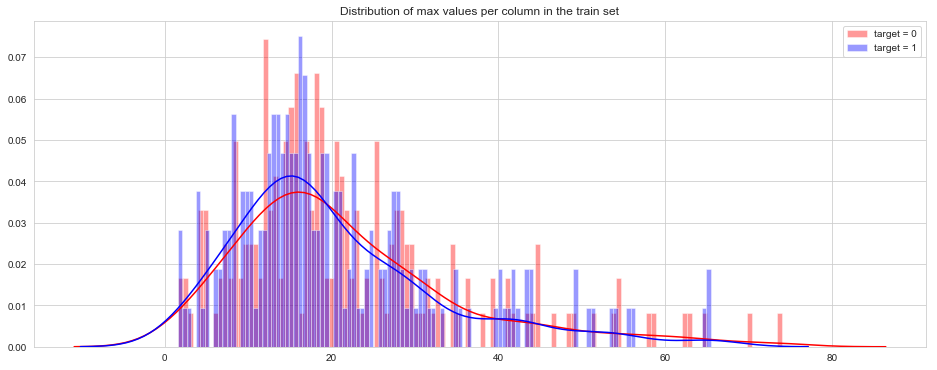

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Testing data

In [6]:
test_df = pd.read_csv('C:/Users/Dell/Desktop/Kaggle/santander/test.csv')

In [7]:
X_test = test_df.drop('ID_code',axis=1)

In [8]:
X = train_df.drop(['ID_code','target'],axis=1)
y = train_df['target']

# Light Gradient Boosting Method

In [9]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [10]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [11]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
            
    #y_pred_valid = model.predict(X_valid)
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/5


Fold 0 started at Thu Feb 28 12:44:14 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.827918	valid_1's auc: 0.814605
[600]	training's auc: 0.862802	valid_1's auc: 0.845745
[900]	training's auc: 0.880631	valid_1's auc: 0.860844
[1200]	training's auc: 0.891953	valid_1's auc: 0.869908
[1500]	training's auc: 0.900115	valid_1's auc: 0.876263
[1800]	training's auc: 0.906338	valid_1's auc: 0.88068
[2100]	training's auc: 0.911263	valid_1's auc: 0.884034
[2400]	training's auc: 0.915172	valid_1's auc: 0.886626
[2700]	training's auc: 0.918385	valid_1's auc: 0.888726
[3000]	training's auc: 0.921196	valid_1's auc: 0.890411
[3300]	training's auc: 0.923598	valid_1's auc: 0.891873
[3600]	training's auc: 0.925717	valid_1's auc: 0.893051
[3900]	training's auc: 0.927648	valid_1's auc: 0.894246
[4200]	training's auc: 0.929203	valid_1's auc: 0.895105
[4500]	training's auc: 0.930731	valid_1's auc: 0.895752
[4800]	training's auc: 0.932079	valid_1's auc: 0.896317
[5

### The LightGBM model gave the accuracy of 89.48% using the Santander Customer Transcation Prediction

# CatBoost Classifier

In [13]:
from catboost import CatBoostClassifier,Pool
prediction1 = np.zeros(len(X_test))
m = CatBoostClassifier(loss_function="Logloss",eval_metric="AUC",
                       boosting_type = 'Ordered')
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    train_data = Pool(X_train, label=y_train)
    valid_data = Pool(X_valid, label=y_valid)

    model1 = m.fit(train_data,eval_set=valid_data,use_best_model=True,verbose=300)
    
    prediction1 += model1.predict(X_test)/5

Fold 0 started at Thu Feb 28 15:01:37 2019
Learning rate set to 0.132949
0:	test: 0.5395915	best: 0.5395915 (0)	total: 2.26s	remaining: 37m 41s
300:	test: 0.8870964	best: 0.8870964 (300)	total: 9m 20s	remaining: 21m 42s
600:	test: 0.8913247	best: 0.8913249 (597)	total: 16m	remaining: 10m 37s
900:	test: 0.8921000	best: 0.8921000 (900)	total: 20m 11s	remaining: 2m 13s
999:	test: 0.8923032	best: 0.8923204 (990)	total: 21m 37s	remaining: 0us

bestTest = 0.8923203664
bestIteration = 990

Shrink model to first 991 iterations.
Fold 1 started at Thu Feb 28 15:23:40 2019
Learning rate set to 0.132949
0:	test: 0.5392219	best: 0.5392219 (0)	total: 1.85s	remaining: 30m 45s
300:	test: 0.8894480	best: 0.8894480 (300)	total: 9m 7s	remaining: 21m 11s
600:	test: 0.8933879	best: 0.8933879 (599)	total: 14m 55s	remaining: 9m 54s
900:	test: 0.8944467	best: 0.8945299 (893)	total: 19m 10s	remaining: 2m 6s
999:	test: 0.8946811	best: 0.8947751 (983)	total: 20m 43s	remaining: 0us

bestTest = 0.8947751446
bestIt

### The Catboost model gave the accuracy of 89.10% using the Santander Customer Transcation Prediction

# XGBoosting

In [14]:
mod = xgb.XGBClassifier(max_depth=4,n_estimators=999999, colsample_bytree=0.7,subsample = 0.7, 
                              min_child_weight = 50, eval_metric = "auc",gamma = 5,alpha = 0,
                               booster = "gbtree",colsample_bylevel = 0.7, learning_rate=0.1,
                              objective='binary:logistic', n_jobs=-1)

prediction2 = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    #evallist = [(valid_data, 'eval'), (train_data, 'train')]
    model2 = mod.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=200, eval_metric='auc',
                        early_stopping_rounds=200)
    
    prediction2 += model2.predict(X_test, ntree_limit=model2.best_ntree_limit)/5

Fold 0 started at Thu Feb 28 18:18:40 2019
[0]	validation_0-auc:0.60766
Will train until validation_0-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.871004
[400]	validation_0-auc:0.886465
[600]	validation_0-auc:0.891015
[800]	validation_0-auc:0.892374
[1000]	validation_0-auc:0.892688
Stopping. Best iteration:
[959]	validation_0-auc:0.892841

Fold 1 started at Thu Feb 28 18:51:06 2019
[0]	validation_0-auc:0.598816
Will train until validation_0-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.872368
[400]	validation_0-auc:0.887945
[600]	validation_0-auc:0.893176
[800]	validation_0-auc:0.894424
[1000]	validation_0-auc:0.894634
[1200]	validation_0-auc:0.894634
Stopping. Best iteration:
[1176]	validation_0-auc:0.894919

Fold 2 started at Thu Feb 28 19:31:44 2019
[0]	validation_0-auc:0.575435
Will train until validation_0-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.875978
[400]	validation_0-auc:0.891846
[600]	validation_0-auc:0.897075
[800]	validation_

### The XGBoost model gave the accuracy of 89.21% using the Santander Customer Transcation Prediction

<table style="text-align:left"> 
    <thead> 
    <tr> <th>Number</th> <th>Model Name</th> <th>Accuray</th> </tr> </thead> <tbody> 
    <tr> 
        <tr> <th scope='row'>2</th> <td style="text-align:center">XGBoosting</td>  <td>0.8921</td> </tr>
        <tr> <th scope='row'>3</th> <td style="text-align:center">CatBoosting</td>  <td>0.8910</td> </tr>
    <tr> <th scope='row'>4</th> <td style="text-align:center">LightGBM</td>  <td>0.8948</td> </tr>

# Predictions

In [15]:
prediction

array([0.08114897, 0.2424331 , 0.21381503, ..., 0.003254  , 0.09354758,
       0.07144961])

From the above predictions, it seems that lightgbbm gives the best results as compared to other models.It gives an accuracy of 89% which is better than other models like XGBoosting and CatBoosting.This increased our rank in the Santander_Customer_Transaction_Prediction from 1948 to 589 which gave better results.

In [16]:
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = prediction
sub.to_csv("submission.csv", index=False)

In [17]:
sub["target"] = prediction1
sub.to_csv("submission1.csv", index=False)

In [18]:
sub["target"] = (prediction + prediction1)/2
sub.to_csv("submission2.csv", index=False)

In [19]:
sub["target"] = prediction2
sub.to_csv("submission3.csv", index=False)

In [20]:
sub["target"] = (prediction + prediction2)/2 
sub.to_csv("submission4.csv", index=False)

In [21]:
sub["target"] = (prediction + prediction1 + prediction2)/3 
sub.to_csv("submission5.csv", index=False)

# License
Must have a license such as the MIT License https://opensource.org/licenses/MIT
MIT License

Copyright (c) 2019 Rajeshree Kale

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



# Citations

Exploratory Data Analysis: https://www.kaggle.com/gpreda/santander-eda-and-prediction

H2O AutoML: https://github.com/nikbearbrown/Kaggle/blob/master/NBB_Zillow_House_Price_Prediction_Feature_Selection.ipynb

LightGBM : https://www.kaggle.com/deepak525/sctp-lightgbm-lb-0-899

XGBoost Classifier : https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

XGBoost Regression : https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

Hyper parameter tuning: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# Conclusion

We used the Santander_Transaction_Customer_Prediction dataset to predict the target by initially running the base model on H2O AutoML and got ensembled stack learning as the best model with an accuracy of 87.23%. As the first part of the assignment we got a rank of 1948 out of 3000 in the Kaggle Competition which was not a good score and then we started to train the model using LightGBM and predicted the target.We ran 3 models which were LightGBM, catboost and XGboost. Lightgbm predicted the best accuracy out of all the 3 models. The final step was tunning the hyperparameters of the model by adding more number of leaves, maxbin,reducing the learning rate,max_depth and num_leaves.We got an accuracy of 89.95% which was better than previous model accuracy.We got even better outcome of 589 out of 3000 in the Kaggle Cometition leaderboard after tunning the hyperparameters.Finally, we conclude that out of all the models, lightgbm performed well which gave the accuracy of 89.48% and after hyperparameter tuning the accuracy changed to 89.95%.

<table style="text-align:left"> 
    <thead> 
    <tr> <th>Number</th> <th>Model Name</th> <th>Accuray</th> </tr> </thead> <tbody> 
    <tr> 
         <th scope='row'>1</th> <td style="text-align:center">H2O AutoML</td> <td>0.8723</td> </tr> 
        <tr> <th scope='row'>2</th> <td style="text-align:center">XGBoosting</td>  <td>0.8921</td> </tr>
        <tr> <th scope='row'>3</th> <td style="text-align:center">CatBoosting</td>  <td>0.8910</td> </tr>
    <tr> <th scope='row'>4</th> <td style="text-align:center">LightGBM</td>  <td>0.8948</td> </tr>
            <tr> <th scope='row'>5</th> <td style="text-align:center">Hyperparameter Tuning</td>  <td>0.8995</td> </tr>

# Contributions
1)The Santander_Transaction_Customer_Prediction dataset which we used we had to predict the probability to identify which products and services might help them achieve their monetary goals.

2)The first task was performing H2O AutoML which gave the best model for our predction. We referred Professor Nik Brown's notebook for that and we reduced the features from 201 to 44. Along with that, we also ranked the importance of the variables and deleted some variables according to the threshold and then used that dataset to be trained by H2O.

3)We extended the model by hyperparameter tunning using GridSearch CV to improve the model performance.In this we tunned the hyperparameters of the model by adding more number of leaves, maxbin,reducing the learning rate,max_depth and num_leaves.

4)We made use of Boosting ensembled learning methods and we used an additional boosting which was lightGBM and Catboosting. 